# Disentangling Key Indicators for Patients' Mortality Rate in Intensive Care Units
*By Team ABC**

***A** for **A**shley Hu, **B** for **B**etty Wu and **C** for Lu**C**as Zhang


# 0. Introduction

*This report follows the Pythonic Style in that it starts with 0.*

Since the digitalization of health records, the amount of electronic health records (EHRs) has been growing at an unprecedent rate. EHRs comprise comprehensive patient data from a wide variety of meansures, including vital sign meansurements, input/output values, patients’ clinical outcomes, medications, procedures, and laboratory test results. Thoughtful analyses and modelings based on the vast amount of high-resolution healthcare data can empower clinicians to access patients’ physical insights that were not available previously. In return, hospitals can provide more personalized and better treatments to patients. 

Predicting patients’ in-hospital mortality is a area of active research. Accurate predictions of clinical outcome enables clinicians to gauge patients condition and facilitate cost-effective management of hospital resources. Given the importance of this issue, in this project we are interested in **using a large-scale, high-resolution MIMIC-III data to predict in-hospital mortality**. We compare the performances of different machine learning models, **including logistic regression, random forest, and neural networks**. **We are able to achieve 0.71 AUC score on the neural network model. Our results indicate that EHRs including MIMIC data have strong predictive power on in-hospital mortality. Factors such as the duration of ICU stay and white blood cell abnormal lab results are highly predictive of in-hospital mortality.**

# 1. Data Description

### 1.1. Data collection

The dataset MIMIC III (Medical Information Mart for Intensive Care) is used in our proejct. MIMIC III is a single-center database concerning  patient admissions to critical care units. While full description can be found from [physionet.org](https://physionet.org/content/mimiciii/1.4/), the database incorprated several data sources, including:

- critical care information systems:
    - Two different systems: Philips **CareVue** and iMDsoft **MetaVision** ICU. Most of data from the two systems was merged expect for fluid intake. The data that are not merged will be given a suffix to distinguish the data source, e.g. "*CV*" for CareVue and "*MV*" for MetaVision. These two systems provided clinical data including:
        - physiological measurements, e.g. heart rate, arterial blood pressure, or respiratory rate;
        - documented progress notes by care providers;
        - drip medications and fluid balances.
- hospital electronic health records:
    - patient demographics
    - in-hospital mortality
    - laboratory test results, including hematology, chemistry and microbiology results.
    - discharge summaries
    - reports of electrocardiogram and imaging studies.
    - *billing-related information* such as International Classification of Disease, 9th Edition (ICD-9) codes, Diagnosis Related Group (DRG) codes, and Current Procedural Terminology (CPT) codes.
- Social Security Administration Death Master File.
    - Out-of-hospital mortality dates

### 1.2. De-identification Processes

Deidentified using *structured data cleansing* and *date shifting*. 

1. Removal of patient name, telephone number, address. 
2. Dates were shifted into the future. intervals preserved. Time of day, day of the week, and approximate seasonality were conserved.
3. **Patients > 89 yrs appear with ages of over 300 yrs.**
4. Protected health information was removed, such as diagnostic reports and physician notes.

### 1.3. Data Description

- **A relational database** consisting of 26 tables linked by identifiers which usually have the suffix ‘ID’, e.g. 
    - SUBJECT_ID (a unique patient)
    - HADM_ID (a unique admission to the hospital), and 
    - ICUSTAY_ID (a unique admission to an intensive care unit)
- Five tables track **patient stays**: ADMISSIONS; PATIENTS; ICUSTAYS; SERVICES; and TRANSFERS
- Another five tables are **dictionaries** (prefixed with ‘D_’): D_CPT; D_ICD_DIAGNOSES; D_ICD_PROCEDURES; D_ITEMS; and D_LABITEMS. 
    - Dictionary tables: Definitions for identifiers. E.g. ITEMID in CHARTEVENTS is explained in D_ITEMS, which represents the concept measured.
- The remaining tables associated with patient care, such as physiological measurements, caregiver observations, and billing information.
- **‘Events’ tables**: a series of charted events such as notes, laboratory tests, and fluid balance. e.g. the OUTPUTEVENTS table: all measurements related to output for a given patient, the LABEVENTS table: laboratory test results for a patient.

# 2. Variables of Interest (Variable Definition)

### 2.1. ID Variables
- SUBJECT_ID: ID variable obtained from *ADMISSIONS.csv*. One unique subject id was assigned to each patient.
- HADM_ID: ID variable obtained from *ADMISSIONS.csv*. **Primary key**. One unique Hospital ADMinistration ID (HADM_ID) was assgined to each hopspitalization of one patient, while multiple HADM_ID may correspond to the same person.
- ADMITTIME: datetime variable obtained from *ADMISSIONS.csv*. This variable records the time when the hospitalization started.
- DISCHTIME: datetime variable obtained from *ADMISSIONS.csv*. This variable records the time when the hospitalization ended.

### 2.2. Output:
- HOSPITAL_EXPIRE_FLAG: Boolean variable obtained from *ADMISSIONS.csv*. This variable indicates whether the patient passed away during hospitalization.

### 2.3 Input:
- ETHNICITY: categorical variable obtained from *ADMISSIONS.csv*. **Demographic information**.
- DIAGNOSIS: string variable obtained from *ADMISSIONS.csv*.
- GENDER: categorical variable obtained from *PATIENTS.csv* via joining on SUBJECT_ID. **Demographic information**. 
- DOB: datetime variable obtained from *PATIENTS.csv* via joining on SUBJECT_ID. **Demographic information**. 
- AGE_ON_AD: numeric variable derived from DOB and ADMITTIME. **Demographic information**. This variable represents the patients' age on administration. An age greater than 300 indicates patients' age greater than 89.
- SERVICES: multi-valued categorical variable obtained from *SERVICES.csv* via joining on SUBJECT_ID and HADM_ID. This variable indicates services that the patients utilized during hospitalization.
- ICU_STAY_DAYS: numeric variable derived from *ICUSTAY.csv*. This variable presents total days of ICU stays during this hospitalization.
- MULTI_ENTRY_ICU: Boolean variable derived from *ICUSTAY.csv*. MULTI_ENTRY_ICU is set True if patients have entered the ICU before this hospitlization. 
- ICD9_code: ten Boolean variables derived from *PROCEDURES_ICD.csv* via joining on SUBJECT_ID and HADM_ID. These variables provided information on the ten most frequent procedures associated with hospitalization.
- TOTAL_ITEMID_code: twenty integer variables derived from *LABEVENTS.csv* via joining on SUBJECT_ID and HADM_ID. These variables provided information on the twenty most frequent lab tests during hospitalization. TOTAL_ITEMID_code indicates how many times the lab test have been carried out in each hospitalization.
- ABNORMAL_ITEMID_code: twenty integer variables derived from *LABEVENTS.csv* via joining on SUBJECT_ID and HADM_ID. Different from TOTAL_ITEMID_code, ABNORMAL_ITEMID_code indicates how many lab tests of this kind were abnormal.

### 2.4. ICD9 Code:

| ICD9 code | Explanation |
| :-: | :-: |
|3961|Extracorporeal circulat|
|3891|Arterial catheterization|
|3893|Venous cath NEC|
|8856|Coronar arteriogr-2 cath|
|9604|Insert endotracheal tube|
|966| Entral infus nutrit sub|
|9671|Cont inv mec ven <96 hrs|
|9672|Cont inv mec ven 96+ hrs|
|9904|Packed cell transfusion|
|9955|Vaccination NEC|

### 2.5. Lab Items code:

|ITEMID|LABEL|FLUID| CATEGORY|
| :-: | :-: | :-: | :-: |
|50820|pH|Blood|Blood Gas|
|50868|Anion Gap| Blood| Chemistry|
|50882|Bicarbonate| Blood| Chemistry|
|50902|Chloride| Blood| Chemistry|
|50912|Creatinine| Blood| Chemistry|
|50931|Glucose| Blood| Chemistry|
|50960|Magnesium| Blood| Chemistry|
|50970|Phosphate| Blood| Chemistry|
|50971|Potassium| Blood| Chemistry|
|50983|Sodium| Blood| Chemistry|
|51006|Urea Nitrogen| Blood| Chemistry|
|51221|Hematocrit| Blood| Hematology|
|51222|Hemoglobin| Blood| Hematology|
|51248|MCH| Blood| Hematology|
|51249|MCHC| Blood| Hematology|
|51250|MCV| Blood| Hematology|
|51265|Platelet Count| Blood| Hematology|
|51277|RDW | Blood| Hematology|
|51279|Red Blood Cells| Blood| Hematology|
|51301|White Blood Cells|Blood| Hematology|

# 3. logistic regression and random forest models

These models provide us detailed information about prediction accuracy and important variables affecting whether a patient dies after admitted into ICU.

### 3.1. Preparing data for further analysis

In this section, we will 
1. load required packages and read in the data,
2. set "age", "gender" and "ethnicity",
3. deal with missing data, and 
4. split the data set randomly into training and test dataset.

In [33]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  roc_auc_score, precision_score, recall_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import plot_partial_dependence
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from numpy import mean
from numpy import std
from pprint import pprint

In [2]:
df = pd.read_csv('MIMIC_cleaned.csv')

In [3]:
age = df.AGE_ON_AD.astype(str).str.split(".", expand=True)[[0]]
age = age.astype(int)
np.sort(age[0][age[0] < 100].unique())
df["age"] = np.where(age[0] > 89, 90, age[0])

In [4]:
le = LabelEncoder()
df["gender"] = le.fit_transform(df.GENDER)

In [5]:
df["ethnicity"] = le.fit_transform(df.ETHNICITY)

In [6]:
#missing data
#replece NA with 0
df.fillna(0, inplace=True)

##### 3.1.1. Spliting into Training and Test Datasets

We randomly split 80% of data, including 47180 cases, into the training dataset and 20%, including 11796 cases, into the test dataset. 

In [7]:
y = df['HOSPITAL_EXPIRE_FLAG']

In [8]:
features_li = ['age', 'gender', 'ethnicity','ICU_STAY_DAYS', 'MULTI_ENTRY_ICU', 
               'ICD9_9955','ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672', 'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
               'PROP_ITEMID_51221', 'PROP_ITEMID_51222',
                'PROP_ITEMID_51248', 'PROP_ITEMID_51249', 'PROP_ITEMID_51250',
                'PROP_ITEMID_51265', 'PROP_ITEMID_51277', 'PROP_ITEMID_51279',
                'PROP_ITEMID_51301', 'PROP_ITEMID_50820', 'PROP_ITEMID_50868',
                'PROP_ITEMID_50882', 'PROP_ITEMID_50902', 'PROP_ITEMID_50912',
                'PROP_ITEMID_50931', 'PROP_ITEMID_50960', 'PROP_ITEMID_50970',
                'PROP_ITEMID_50971', 'PROP_ITEMID_50983', 'PROP_ITEMID_51006']
X = df[features_li]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
 test_size=0.2, random_state=0)

In [10]:
X_train.shape

(47180, 35)

In [11]:
X_test.shape

(11796, 35)

### 3.2. Logistic regression

In this section, we are going to construct a simple model, logistic regression, to predict the clinical outcome based on various variables in the MIMIC dataset. We will also evaluate the model accuracy via confusion matrix and AUC (area under the curve). In addition, we may want to check which variables are the most important variables in our model.

##### 3.2.1. Construct Logistic regression model

In [12]:
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)

##### 3.2.2. Evaluate our Model

We will evaluate the accuracy of our model on the test dataset and visualize the accuracy via confusion matrix, which shows the estimated type I error rate and type II error rate. We will also calculate the AUC of our model.

In [13]:
predictions = logisticRegr.predict(X_test)

In [14]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.921414038657172


In [15]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)

Text(0.5, 225.76, 'Predicted label')

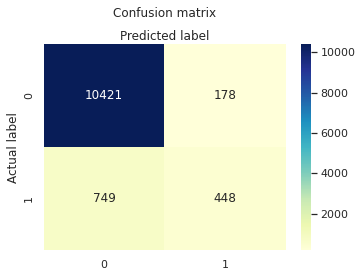

In [16]:
sns.set(rc={'figure.figsize':(5,3.5)})
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Interpretation**: Our results shows the logistic regression model is highly accurate. In the test dataset, it predicts the ICU mortality with 92% accuracy. However, as shown in the confusion matrix, 88% of patients who entered ICU did not pass away. Therefore, the high accuracy should be interpreted with caution as it may be partially due to our model prediction capacity and partially due to imbalanced dataset. 

Subsequently, we would like to estimate the AUC of the logitic regression model. AUC compares the true positive rate with false posititve rate; therefore, AUC can be a better indicator of accuracy for such an imbalanced dataset.

In [47]:
print("Logistic auc score:", roc_auc_score(y_test, predictions))

Logistic auc score: 0.6787374843373174


In [46]:
print("Logistic Accuracy:", accuracy_score(y_test, predictions))
print("Logistic Precision:", precision_score(y_test, predictions))
print("Logistic Recall:", recall_score(y_test, predictions))
print(classification_report(y_test, predictions))

Logistic Accuracy: 0.921414038657172
Logistic Precision: 0.7156549520766773
Logistic Recall: 0.3742690058479532
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     10599
           1       0.72      0.37      0.49      1197

    accuracy                           0.92     11796
   macro avg       0.82      0.68      0.72     11796
weighted avg       0.91      0.92      0.91     11796



**Interpretation**: Accoring to our results, the AUC of the logistic regression model is estiamted at 0.68, which is considerably greater than random guess (AUC = 0.5). Therefore, we expect that some variables in our dataset are associated with the clinical outcome (mortality in ICU). In the following section, we will explore the variable importance in our logistic regression model.

##### 3.2.3. Variable Selection

As indicated in the logistic regression model, there are some variables associated with the outcome of itnerest. In this section, we would like to dive into the model, and further analyze which set of variables may better predict the mortality in ICU.

In [45]:
#Get feature importance by coefficient
zip_iterator = zip(X_train.columns, logisticRegr.coef_[0])
coef_logit = dict(zip_iterator) 
sort_coef = sorted(coef_logit.items(), key=lambda x: x[1], reverse=True)
for i in sort_coef:
    print(i[0], i[1])

PROP_ITEMID_50868 1.8645790883647906
ICD9_9672 1.4511753097322155
PROP_ITEMID_51301 1.4475841463494903
PROP_ITEMID_50983 1.3377124530489855
ICD9_9671 1.1818503651620078
PROP_ITEMID_50971 1.0184823548913697
PROP_ITEMID_50931 0.8877412932208923
PROP_ITEMID_50820 0.8767619107646165
PROP_ITEMID_50882 0.7954872886149137
PROP_ITEMID_51265 0.7894341574004886
PROP_ITEMID_50960 0.5786971859117579
PROP_ITEMID_51277 0.43512413457315696
PROP_ITEMID_51006 0.3456510193749629
ICD9_3891 0.2896410660891787
PROP_ITEMID_50912 0.2502789746676442
PROP_ITEMID_50970 0.24960537101485
ICD9_9604 0.1711645801657197
PROP_ITEMID_50902 0.1656892891886428
gender 0.1342352743918911
PROP_ITEMID_51249 0.12978116454334035
PROP_ITEMID_51250 0.12616722963521448
PROP_ITEMID_51248 0.09856121614296526
PROP_ITEMID_51279 0.06923409328689456
age 0.03179557160589237
ICD9_9904 0.03097310127680012
ethnicity 0.0161527292746418
ICU_STAY_DAYS -0.009038124972159499
ICD9_3893 -0.05776181388285242
ICD9_8856 -0.12221807164259228
MULTI_EN

**Interpretaion**: ***The table lists the coefficients of the logistic regression model. A greater absolute value of coefficient may indicate a stronger association with the outcome, while a coefficient >0 indicates an increased risk while that <0 indicates an decreased risk. Accoording to the table above, we can identify 7 factors which have a coefficient >1 or < -1, including ITEMID_50868, ICD9_9672, ITEMID_51301, ITEMID_50983, ICD9_9671, ITEMID_50971, ICD9_3961 and ICD9_9955. ***

### Random forest hyperparameter tuning

In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 600, stop = 1000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(100,500, num = 3)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True]
class_weight = ["balanced", "balanced_subsample"]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'class_weight': class_weight}
pprint(random_grid)

{'class_weight': ['balanced', 'balanced_subsample'],
 'max_depth': [100, 300, 500, None],
 'n_estimators': [600, 800, 1000]}


In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
random.seed(2021)
randomforest = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = randomforest,
                               param_distributions = random_grid, 
                               n_iter = 1000, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1, scoring='roc_auc').fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 24 is smaller than n_iter=1000. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 14.2min finished


In [23]:
rf_random.best_params_

{'n_estimators': 1000, 'max_depth': 300, 'class_weight': 'balanced'}

In [24]:
y_pred = rf_random.best_estimator_.predict(X_test)

In [25]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

Text(0.5, 225.76, 'Predicted label')

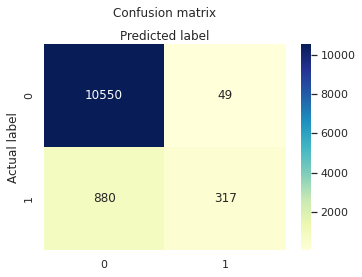

In [26]:
sns.set(rc={'figure.figsize':(5,3.5)})
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [42]:
print("Random forest auc score:", roc_auc_score(y_test, y_pred))

Random forest auc score: 0.6301028304320572


In [39]:
print("Random forest Accuracy:", accuracy_score(y_test, y_pred))
print("Random forest Precision:", precision_score(y_test, y_pred))
print("Random forest Recall:", recall_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Random forest Accuracy: 0.921244489657511
Random forest Precision: 0.8661202185792349
Random forest Recall: 0.264828738512949
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10599
           1       0.87      0.26      0.41      1197

    accuracy                           0.92     11796
   macro avg       0.89      0.63      0.68     11796
weighted avg       0.92      0.92      0.90     11796



In [29]:
feature_imp = pd.Series(rf_random.best_estimator_.feature_importances_,index=X.columns).sort_values(ascending=False)

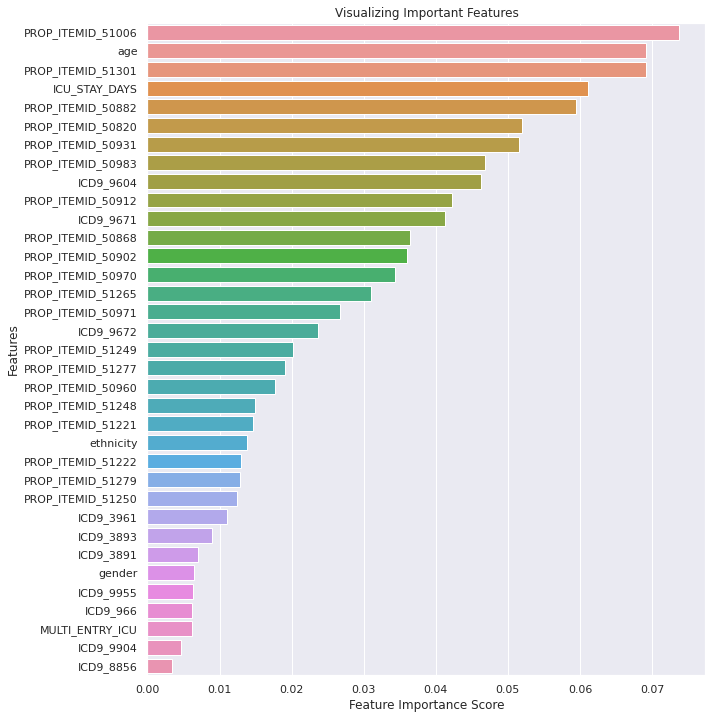

In [30]:
sns.set(rc={'figure.figsize':(10,12)})
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Deep learning model

Deep leaning model can be trained to a high prediction accuracy so that we can predict a patient who have a high risk after admitted into ICU.

### Preparing Data for further analysis

<a href="https://colab.research.google.com/github/JiamanBettyWu/bios823_project/blob/betty/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/BIOS823/BIOS823 Final Project')

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  roc_auc_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


import joblib

In [4]:
dat = pd.read_csv("/content/drive/MyDrive/BIOS823/BIOS823 Final Project/MIMIC_cleaned.csv")

In [ ]:
dat.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,GENDER,DOB,AGE_ON_AD,SERVICES,ICU_STAY_DAYS,MULTI_ENTRY_ICU,ICD9_9955,ICD9_3893,ICD9_9604,ICD9_966,ICD9_9672,ICD9_9904,ICD9_9671,ICD9_3961,ICD9_8856,ICD9_3891,TOTAL_ITEMID_51221,TOTAL_ITEMID_51222,TOTAL_ITEMID_51248,TOTAL_ITEMID_51249,TOTAL_ITEMID_51250,TOTAL_ITEMID_51265,TOTAL_ITEMID_51277,TOTAL_ITEMID_51279,TOTAL_ITEMID_51301,TOTAL_ITEMID_50820,TOTAL_ITEMID_50868,TOTAL_ITEMID_50882,TOTAL_ITEMID_50902,TOTAL_ITEMID_50912,TOTAL_ITEMID_50931,TOTAL_ITEMID_50960,TOTAL_ITEMID_50970,...,ABNORMAL_ITEMID_51221,ABNORMAL_ITEMID_51222,ABNORMAL_ITEMID_51248,ABNORMAL_ITEMID_51249,ABNORMAL_ITEMID_51250,ABNORMAL_ITEMID_51265,ABNORMAL_ITEMID_51277,ABNORMAL_ITEMID_51279,ABNORMAL_ITEMID_51301,ABNORMAL_ITEMID_50820,ABNORMAL_ITEMID_50868,ABNORMAL_ITEMID_50882,ABNORMAL_ITEMID_50902,ABNORMAL_ITEMID_50912,ABNORMAL_ITEMID_50931,ABNORMAL_ITEMID_50960,ABNORMAL_ITEMID_50970,ABNORMAL_ITEMID_50971,ABNORMAL_ITEMID_50983,ABNORMAL_ITEMID_51006,PROP_ITEMID_51221,PROP_ITEMID_51222,PROP_ITEMID_51248,PROP_ITEMID_51249,PROP_ITEMID_51250,PROP_ITEMID_51265,PROP_ITEMID_51277,PROP_ITEMID_51279,PROP_ITEMID_51301,PROP_ITEMID_50820,PROP_ITEMID_50868,PROP_ITEMID_50882,PROP_ITEMID_50902,PROP_ITEMID_50912,PROP_ITEMID_50931,PROP_ITEMID_50960,PROP_ITEMID_50970,PROP_ITEMID_50971,PROP_ITEMID_50983,PROP_ITEMID_51006
0,22,165315,2196-04-09T12:26:00Z,2196-04-10T15:54:00Z,WHITE,BENZODIAZEPINE OVERDOSE,0,F,2131-05-07T00:00:00Z,64.926812,MED,1.1438,False,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.000,0.50,0.0,0.000000
1,23,152223,2153-09-03T07:15:00Z,2153-09-08T19:10:00Z,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,M,2082-07-17T00:00:00Z,71.130191,CSURG,1.2641,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,9.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,13.0,2.0,3.0,3.0,4.0,3.0,6.0,1.0,...,9.0,3.0,1.0,3.0,0.0,4.0,0.0,3.0,0.0,8.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,1.000000,0.0,1.000,0.0,1.0,0.000000,0.615385,0.000000,0.000000,0.666667,0.000000,1.000000,0.0,0.000,0.00,0.0,0.000000
2,23,124321,2157-10-18T19:34:00Z,2157-10-25T14:00:00Z,WHITE,BRAIN MASS,0,M,2082-07-17T00:00:00Z,75.254799,NSURG,1.1862,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,2.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,3.0,6.0,0.0,1.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,3.0,0.0,0.0,3.0,1.0,1.0,0.375000,0.750000,0.0,0.125,0.0,1.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.375,0.00,0.0,0.375000
3,24,161859,2139-06-06T16:14:00Z,2139-06-09T12:48:00Z,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,M,2100-05-31T00:00:00Z,39.016226,CMED,0.5124,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.000,0.00,0.0,0.000000
4,25,129635,2160-11-02T02:06:00Z,2160-11-05T14:55:00Z,WHITE,ACUTE CORONARY SYNDROME,0,M,2101-11-21T00:00:00Z,58.948905,CMED,3.5466,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,9.0,7.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,8.0,9.0,9.0,9.0,9.0,9.0,8.0,8.0,...,9.0,7.0,0.0,4.0,0.0,1.0,0.0,7.0,4.0,5.0,1.0,2.0,3.0,4.0,8.0,0.0,5.0,3.0,0.0,7.0,1.0,1.0,0.000000,0.571429,0.0,0.125,0.0,1.0,0.571429,0.625000,0.111111,0.222222,0.333333,0.444444,0.888889,0.0,0.625,0.25,0.0,0.777778


In [ ]:
dat.shape

(58976, 83)

In [ ]:
dat.describe()

,SUBJECT_ID,HADM_ID,HOSPITAL_EXPIRE_FLAG,AGE_ON_AD,ICU_STAY_DAYS,ICD9_9955,ICD9_3893,ICD9_9604,ICD9_966,ICD9_9672,ICD9_9904,ICD9_9671,ICD9_3961,ICD9_8856,ICD9_3891,TOTAL_ITEMID_51221,TOTAL_ITEMID_51222,TOTAL_ITEMID_51248,TOTAL_ITEMID_51249,TOTAL_ITEMID_51250,TOTAL_ITEMID_51265,TOTAL_ITEMID_51277,TOTAL_ITEMID_51279,TOTAL_ITEMID_51301,TOTAL_ITEMID_50820,TOTAL_ITEMID_50868,TOTAL_ITEMID_50882,TOTAL_ITEMID_50902,TOTAL_ITEMID_50912,TOTAL_ITEMID_50931,TOTAL_ITEMID_50960,TOTAL_ITEMID_50970,TOTAL_ITEMID_50971,TOTAL_ITEMID_50983,TOTAL_ITEMID_51006,ABNORMAL_ITEMID_51221,ABNORMAL_ITEMID_51222,ABNORMAL_ITEMID_51248,ABNORMAL_ITEMID_51249,ABNORMAL_ITEMID_51250,ABNORMAL_ITEMID_51265,ABNORMAL_ITEMID_51277,ABNORMAL_ITEMID_51279,ABNORMAL_ITEMID_51301,ABNORMAL_ITEMID_50820,ABNORMAL_ITEMID_50868,ABNORMAL_ITEMID_50882,ABNORMAL_ITEMID_50902,ABNORMAL_ITEMID_50912,ABNORMAL_ITEMID_50931,ABNORMAL_ITEMID_50960,ABNORMAL_ITEMID_50970,ABNORMAL_ITEMID_50971,ABNORMAL_ITEMID_50983,ABNORMAL_ITEMID_51006,PROP_ITEMID_51221,PROP_ITEMID_51222,PROP_ITEMID_51248,PROP_ITEMID_51249,PROP_ITEMID_51250,PROP_ITEMID_51265,PROP_ITEMID_51277,PROP_ITEMID_51279,PROP_ITEMID_51301,PROP_ITEMID_50820,PROP_ITEMID_50868,PROP_ITEMID_50882,PROP_ITEMID_50902,PROP_ITEMID_50912,PROP_ITEMID_50931,PROP_ITEMID_50960,PROP_ITEMID_50970,PROP_ITEMID_50971,PROP_ITEMID_50983,PROP_ITEMID_51006
count,58976.000000,58976.000000,58976.000000,58976.000000,57776.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000
mean,33755.583288,149970.809584,0.099261,64.430758,5.236836,0.151418,0.381810,0.267819,0.241045,0.156757,0.187756,0.235861,0.177233,0.138329,0.122777,12.106937,10.069802,10.005619,10.008010,10.005567,10.452282,9.988116,10.005689,10.081494,9.154524,10.616281,10.795184,11.023087,10.812704,10.394119,9.763843,8.550563,11.689730,11.200995,10.771905,11.043626,9.142448,2.661879,2.198482,1.615042,4.060606,4.572742,9.188954,4.672646,3.412721,0.729413,3.139482,3.214152,4.303743,7.368851,0.952604,3.285891,1.310584,1.951575,6.105052,0.811593,0.833540,0.350801,0.216018,0.225673,0.273800,0.399586,0.806873,0.405611,0.261551,0.058487,0.238493,0.243379,0.279529,0.605629,0.086224,0.307228,0.104655,0.118382,0.416595
std,28092.726225,28883.095213,0.299014,57.198347,10.113915,0.360623,0.582495,0.470856,0.431704,0.371963,0.393827,0.437234,0.384104,0.360383,0.339215,14.259859,11.859442,11.783244,11.786011,11.783184,12.981623,11.769617,11.783247,11.870873,19.383521,13.060470,13.195680,13.447473,13.160066,13.158389,13.032870,12.160094,14.261317,13.856028,13.123008,14.227432,11.790639,5.579006,4.747584,4.401809,10.031740,9.986848,11.800619,8.185210,8.617164,2.361057,6.106399,5.870068,9.427704,10.295676,2.333665,5.731314,2.658228,4.815333,10.988554,0.320891,0.302453,0.431055,0.301046,0.383428,0.349044,0.455942,0.339710,0.360920,0.338676,0.151993,0.298720,0.286536,0.392508,0.343125,0.173735,0.310155,0.179161,0.213524,0.405558
min,2.000000,100001.000000,0.000000,0.000000,0.000200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

### AGE 

To protect patients' privacy, patients who are older than a certain ago is coded by a really large number like 300. Therefore, we would like identify these patients and encode the patients' age by a more reasonable number. 

In [5]:
# AGE_ON_AD is a float, which doesn't really make sense for age
# We want to ignore everything that's after the decimal point

age = dat.AGE_ON_AD.astype(str).str.split(".", expand=True)[[0]]
age = age.astype(int)

In [6]:
# We see that the oldest real age is 89
np.sort(age[0][age[0] < 100].unique())

# So we want to set everything greater than 89 years old as 90
# And saves this back to the dataframe
dat["age"] = np.where(age[0] > 89, 90, age[0])

### GENDER

In [7]:
le = LabelEncoder()

In [8]:
dat["gender"] = le.fit_transform(dat.GENDER)

### Ethnicity

The Ethicity feature is very granular. One potential improvement is to group some of the ethinicity together to reduce overfitting.

In [9]:
dat["ethnicity"] = le.fit_transform(dat.ETHNICITY)

In [ ]:
dat.ETHNICITY.unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

In [10]:
features_li = ['age', 'gender', 'ethnicity','ICU_STAY_DAYS', 'MULTI_ENTRY_ICU', 
               'ICD9_9955','ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672', 'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
               'PROP_ITEMID_51221', 'PROP_ITEMID_51222',
                'PROP_ITEMID_51248', 'PROP_ITEMID_51249', 'PROP_ITEMID_51250',
                'PROP_ITEMID_51265', 'PROP_ITEMID_51277', 'PROP_ITEMID_51279',
                'PROP_ITEMID_51301', 'PROP_ITEMID_50820', 'PROP_ITEMID_50868',
                'PROP_ITEMID_50882', 'PROP_ITEMID_50902', 'PROP_ITEMID_50912',
                'PROP_ITEMID_50931', 'PROP_ITEMID_50960', 'PROP_ITEMID_50970',
                'PROP_ITEMID_50971', 'PROP_ITEMID_50983', 'PROP_ITEMID_51006']
X = dat[features_li]
y = dat['HOSPITAL_EXPIRE_FLAG']

### Missing values

method: fill with 0

In [75]:
# Check the number of missing values in each column
X.isna().sum(axis = 0)

age                  0
gender               0
ethnicity            0
ICU_STAY_DAYS        0
MULTI_ENTRY_ICU      0
ICD9_9955            0
ICD9_3893            0
ICD9_9604            0
ICD9_966             0
ICD9_9672            0
ICD9_9904            0
ICD9_9671            0
ICD9_3961            0
ICD9_8856            0
ICD9_3891            0
PROP_ITEMID_51221    0
PROP_ITEMID_51222    0
PROP_ITEMID_51248    0
PROP_ITEMID_51249    0
PROP_ITEMID_51250    0
PROP_ITEMID_51265    0
PROP_ITEMID_51277    0
PROP_ITEMID_51279    0
PROP_ITEMID_51301    0
PROP_ITEMID_50820    0
PROP_ITEMID_50868    0
PROP_ITEMID_50882    0
PROP_ITEMID_50902    0
PROP_ITEMID_50912    0
PROP_ITEMID_50931    0
PROP_ITEMID_50960    0
PROP_ITEMID_50970    0
PROP_ITEMID_50971    0
PROP_ITEMID_50983    0
PROP_ITEMID_51006    0
dtype: int64

In [11]:
# fill NAs with 0
X = X.fillna(0)

## Train Dev test split

In [24]:
trainX, devX, trainy, devy = train_test_split(X, y, test_size=0.2, random_state=12)


In [25]:
print(f"Train data set size: {trainX.shape}.")
print(f"Test data set size: {devX.shape}.")

Train data set size: (47180, 35).
Test data set size: (11796, 35).


## Scaling

In [26]:
# features need to be normalized

features_norm = ['ICU_STAY_DAYS','ICD9_9955','ICD9_3893', 'ICD9_9604', 'ICD9_966',
                 'ICD9_9672', 'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
                 'PROP_ITEMID_51221', 'PROP_ITEMID_51222',
                 'PROP_ITEMID_51248', 'PROP_ITEMID_51249', 'PROP_ITEMID_51250',
                 'PROP_ITEMID_51265', 'PROP_ITEMID_51277', 'PROP_ITEMID_51279',
                 'PROP_ITEMID_51301', 'PROP_ITEMID_50820', 'PROP_ITEMID_50868',
                 'PROP_ITEMID_50882', 'PROP_ITEMID_50902', 'PROP_ITEMID_50912',
                 'PROP_ITEMID_50931', 'PROP_ITEMID_50960', 'PROP_ITEMID_50970',
                 'PROP_ITEMID_50971', 'PROP_ITEMID_50983', 'PROP_ITEMID_51006']



In [27]:
scaler = StandardScaler()

trainX = scaler.fit_transform(trainX)
devX = scaler.fit_transform(devX)

## MLP Classifier 

In [28]:
classifier = MLPClassifier(hidden_layer_sizes=(150,100), max_iter=500,activation = 'relu',solver='adam',random_state=1)
classifier.fit(trainX, trainy)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(150, 100), max_iter=500, random_state=1)

In [ ]:
from sklearn.model_selection import PredefinedSplit

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(30, 30, 30),(100, 100, 100), (150, 150)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'batch_size': [64, 128, 256]
}
clf = GridSearchCV(classifier, parameter_space, n_jobs=-1, cv=2, scoring='roc_auc', verbose=4)
clf.fit(trainX, trainy)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


GridSearchCV(cv=2,
             estimator=MLPClassifier(hidden_layer_sizes=(150, 100),
                                     max_iter=500, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05], 'batch_size': [64, 128, 256],
                         'hidden_layer_sizes': [(30, 30, 30), (100, 100, 100),
                                                (150, 150)],
                         'learning_rate': ['constant', 'adaptive']},
             scoring='roc_auc', verbose=4)

In [ ]:
import joblib

In [ ]:
clf.best_score_

0.9055029343579268

In [ ]:
joblib.dump(clf, '/content/drive/MyDrive/BIOS823/BIOS823 Final Project/clf_21.pkl')
joblib.dump(clf.best_estimator_, '/content/drive/MyDrive/BIOS823/BIOS823 Final Project/best_clf_21.pkl')

['/content/drive/MyDrive/BIOS823/BIOS823 Final Project/best_clf_21.pkl']

In [ ]:
clf.best_estimator_

MLPClassifier(activation='tanh', alpha=0.05, batch_size=64,
              hidden_layer_sizes=(150, 150), max_iter=500, random_state=1)

In [ ]:
clf.best_params_

{'activation': 'tanh',
 'alpha': 0.05,
 'batch_size': 64,
 'hidden_layer_sizes': (150, 150),
 'learning_rate': 'constant'}

In [ ]:
 confusion_matrix(devy_pred, devy)

array([[5181,  328],
       [ 102,  287]])

In [ ]:
roc_auc_score(devy_pred, devy)

0.8391251333993777

In [22]:
best_clf = joblib.load("/content/drive/MyDrive/BIOS823/BIOS823 Final Project/best_clf_21.pkl")

In [30]:
devy_pred = best_clf.predict(devX)
roc_auc_score(devy, devy_pred)

0.7105518151646653

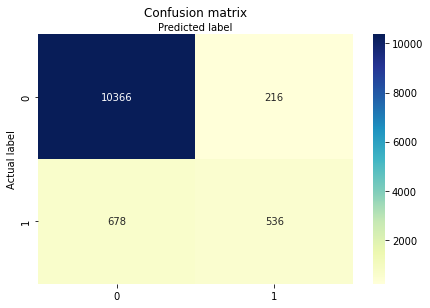

In [39]:
cnf_matrix = confusion_matrix(devy, devy_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [46]:
print("Accuracy:", accuracy_score(devy, devy_pred))
print("Precision:", precision_score(devy, devy_pred))
print("Recall:", recall_score(devy, devy_pred))
print(classification_report(devy, devy_pred))
# print(accuracy_score(devy, devy_pred))

Accuracy: 0.9242115971515769
Precision: 0.7127659574468085
Recall: 0.4415156507413509
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10582
           1       0.71      0.44      0.55      1214

    accuracy                           0.92     11796
   macro avg       0.83      0.71      0.75     11796
weighted avg       0.92      0.92      0.92     11796



## Partial Dependency Plot

The top 5 important factors. 0 stands for the mean and the risk increases with the variables.

In [48]:
from sklearn.inspection import PartialDependenceDisplay

In [70]:
important_features = ["PROP_ITEMID_51006", "PROP_ITEMID_51301", "age", "ICU_STAY_DAYS", "PROP_ITEMID_50882"]


In [72]:
idx = [np.where(X.columns == name) for name in important_features]

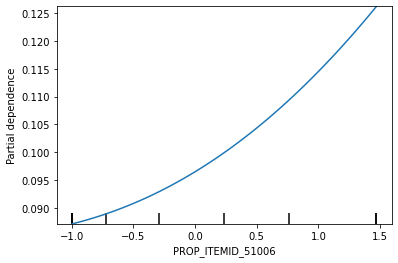

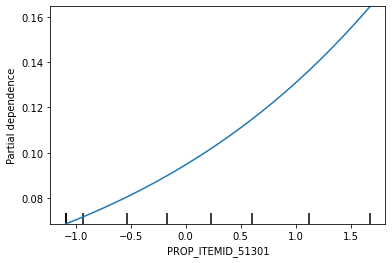

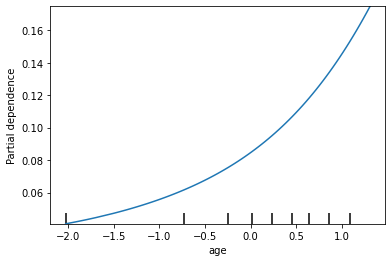

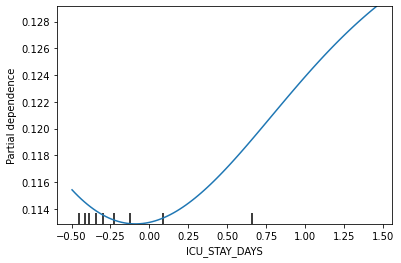

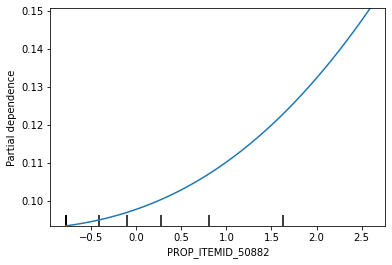

In [74]:
for i in idx:

  PartialDependenceDisplay.from_estimator(best_clf, trainX, features = i, feature_names=X.columns);

# 5. Individual contributions

Lucsa Zhang cleaned and prepared the data, derived the defition of the variables of interests, combined the results and wrote the documentation. Ashley Hu trained the logistic regerssion model, constructed random forest model and tuned its hyperparameters, and interpreted results of these models. Betty Wu constructed the deep learning model, tuned its hyperparameters and interpreted the results. All three team members participated in the drafting and polishing the final report.

Refelection from Betty: Through this project, I learned and honed in on data wrangling skills and developing a machine learning model. More specifically, the MIMIC data consists of several smaller datasets with different sets of features. One of the challenges we faced as a team was understanding the context and relationship between datasets. Learning to understand, wrangle, and clean the complexity surround the data was an important lesson that I learned. Furthermore, from the project, I gained valuable experience training, evaluating, and tuning a multilayer perceptron model. Besides technical skills, I also learned how to work with teammates from different academic backgrounds. Since our team is diverse, I was able to learn from my teammates and leverage our expertise in different areas.

Refelection from Ashley: In this project I learned how modeling works in dealing with real life problem. My main responsibility for this project is to train a logistic regression model and a random forest model. In doing the random forest model, I used hyperparameter tuning to perform a grid search to find the proper parameter to build the random forest model. We also used the scoring = roc_auc to select the parameters that gives the highest auc score. My team members helped me a lot in building these two models. We had regular weekly meetings to discuss about our progress and make the process went smoothly.